In [1]:
import numpy as numpy
import pandas as pd 


In [2]:
import os
os.path.abspath(os.getcwd())

'e:\\Alireza\\Uppsala\\Classes\\Data_Mining\\Project'

In [3]:
df = pd.read_csv("European_citiznes_rsvp.csv")
df.count()
df.dropna()

COUNTRY  SEX    YEAR  life_expectancy  \
0    Austria  ALL  2000.0            78.47   
1    Austria  ALL  2001.0            78.95   
2    Austria  ALL  2002.0            79.01   
3    Austria  ALL  2003.0            78.89   
4    Austria  ALL  2004.0            79.43   
..       ...  ...     ...              ...   
553   Sweden  ALL  2018.0            82.71   
554   Sweden  ALL  2019.0            83.22   
555   Sweden  ALL  2020.0            82.46   
556   Sweden  ALL  2021.0            83.26   
557   Sweden  ALL  2022.0            83.24   

     average_number_of_calories_available_per_person_per_day  \
0                                               2223.0         
1                                               2242.0         
2                                               2156.0         
3                                               2270.0         
4                                               2254.0         
..                                                 ...         
553                                             3411.0         
554                                             3450.0         
555                                             3466.0         
556                                             3527.0         
557                                             3517.0         

     unemployment_rate  regular_daily_smokers  adult_overweight  \
0                  5.6                   29.5             33.30   
1                  5.1                   40.1             33.80   
2                  3.6                   24.7             34.20   
3                  4.4                   34.9             34.70   
4                  5.7                   39.0             35.10   
..                 ...                    ...               ...   
553                6.2                   18.4             52.23   
554                7.9                   15.9             52.76   
555               11.5                   33.0             53.29   
556               14.4                   29.0             53.80   
557               16.2                   28.0             54.32   

     alcahol_consumption_liter_per_capita  fat_available_ppd  protein_ppd  \
0                                    1.17              44.85        66.11   
1                                    0.91              46.06        66.12   
2                                    1.04              43.14        64.58   
3                                    1.04              48.29        65.59   
4                                    1.03              44.41        66.63   
..                                    ...                ...          ...   
553                                  9.00             138.58        96.73   
554                                  9.12             138.96        96.96   
555                                  9.06             140.72        99.18   
556                                  9.36             146.00       102.49   
557                                 10.18             144.11       101.28   

     average_fruit_vegtable_ppd  annual_income  youth_unemployment_rate  \
0                        128.80          700.0                    16.72   
1                        121.44          730.0                    48.34   
2                        115.27          730.0                    40.51   
3                        127.38          760.0                    33.46   
4                        120.52          650.0                    23.42   
..                          ...            ...                      ...   
553                      175.32        60510.0                    15.01   
554                      173.29        58040.0                    12.74   
555                      172.22        56690.0                    11.67   
556                      169.74        61260.0                    13.63   
557                      168.94        63460.0                    15.25   

     Ischaemic_heart_diseas  circulatory_diseases  s

In [4]:
import pandas as pd
import numpy as np

summary = {
    "n_rows": len(df),
    "n_countries": df["COUNTRY"].nunique(),
    "years_min": df["YEAR"].min(),
    "years_max": df["YEAR"].max(),
    "sex_levels": df["SEX"].unique().tolist(),
}
missing = df.isna().mean().sort_values(ascending=False)  # share missing per column

# 2) Per-country trend features (slopes and percent change)
def slope(y, x):
    if len(y.dropna()) < 3: return np.nan
    x = x.astype(float)
    y = y.astype(float)
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m

trend_cols = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
    "unemployment_rate",
    "annual_income",
    "youth_unemployment_rate",
    "Ischaemic_heart_diseas",
    "circulatory_diseases",
    "self_injury",
    "total_hospital_beds"
]

# Work on total (collapse SEX if you have both M/F): take average across SEX within country-year
df_tot = (df.groupby(["COUNTRY","YEAR"], as_index=False)
            [trend_cols].mean())

# Slopes per country
slopes = (df_tot
          .groupby("COUNTRY")
          .apply(lambda g: pd.Series({f"{c}_slope": slope(g[c], g["YEAR"]) for c in trend_cols}))
          .reset_index())

# Percent change 2002 -> 2022
def pct_change_2002_2022(g, col):
    g = g.sort_values("YEAR")
    first = g.loc[g["YEAR"].idxmin(), col] if not g.empty else np.nan
    last  = g.loc[g["YEAR"].idxmax(), col] if not g.empty else np.nan
    return (last - first) / first * 100 if pd.notna(first) and first != 0 else np.nan

pctchg = (df_tot
          .groupby("COUNTRY")
          .apply(lambda g: pd.Series({f"{c}_pctchg": pct_change_2002_2022(g, c) for c in trend_cols}))
          .reset_index())

trend_table = slopes.merge(pctchg, on="COUNTRY", how="outer")

# 3) Associations with life expectancy
# 3a) Overall Pearson correlations (latest year only, e.g., 2022)
latest_year = df_tot["YEAR"].max()
snap = df_tot[df_tot["YEAR"] == latest_year].copy()
corr_cols = ["life_expectancy","average_number_of_calories_available_per_person_per_day",
             "regular_daily_smokers","adult_overweight","alcahol_consumption_liter_per_capita",
             "fat_available_ppd","protein_ppd","average_fruit_vegtable_ppd","unemployment_rate","annual_income",
    "youth_unemployment_rate","Ischaemic_heart_diseas","circulatory_diseases","self_injury","total_hospital_beds"]
corr_latest = snap[corr_cols].corr().loc["life_expectancy"].sort_values(ascending=False)

# 3b) Within-country correlations (demeaned by country)
def demean_by_country(d, cols):
    return d.assign(**{c: d[c] - d.groupby("COUNTRY")[c].transform("mean") for c in cols})
dm = demean_by_country(df_tot, corr_cols)
corr_within = dm[corr_cols].corr().loc["life_expectancy"].sort_values(ascending=False)

# 4) Quick fixed-effects style regression (no external libs)
X_cols = ["average_number_of_calories_available_per_person_per_day",
          "regular_daily_smokers","alcahol_consumption_liter_per_capita",
          "unemployment_rate","annual_income","youth_unemployment_rate","Ischaemic_heart_diseas","circulatory_diseases","self_injury","total_hospital_beds"]
d = df_tot.dropna(subset=["life_expectancy"] + X_cols).copy()
# Add year dummies
year_dummies = pd.get_dummies(d["YEAR"], prefix="Y", drop_first=True)
X = pd.concat([d[X_cols], year_dummies], axis=1)
X = (X - X.mean())/X.std(ddof=0)  # scale for comparability
X["intercept"] = 1.0
y = d["life_expectancy"].astype(float)

# OLS via closed form
XtX = X.T @ X
Xty = X.T @ y
beta = np.linalg.pinv(XtX) @ Xty
coef = pd.Series(beta, index=X.columns).sort_values(ascending=False)

# 5) Country profiles (latest year z-scores)
Z = snap.copy()
for c in corr_cols:
    Z[c + "_z"] = (Z[c] - Z[c].mean()) / Z[c].std(ddof=0)
country_profile = Z[["COUNTRY"] + [c+"_z" for c in corr_cols]]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5976\760741357.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{c}_slope": slope(g[c], g["YEAR"]) for c in trend_cols}))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5976\760741357.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{c}_pctchg": pct_change_2002_2022(g, c) for c in trend_cols}))


In [5]:
missing

COUNTRY                                                    0.0
SEX                                                        0.0
YEAR                                                       0.0
life_expectancy                                            0.0
average_number_of_calories_available_per_person_per_day    0.0
unemployment_rate                                          0.0
regular_daily_smokers                                      0.0
adult_overweight                                           0.0
alcahol_consumption_liter_per_capita                       0.0
fat_available_ppd                                          0.0
protein_ppd                                                0.0
average_fruit_vegtable_ppd                                 0.0
annual_income                                              0.0
youth_unemployment_rate                                    0.0
Ischaemic_heart_diseas                                     0.0
circulatory_diseases                                   

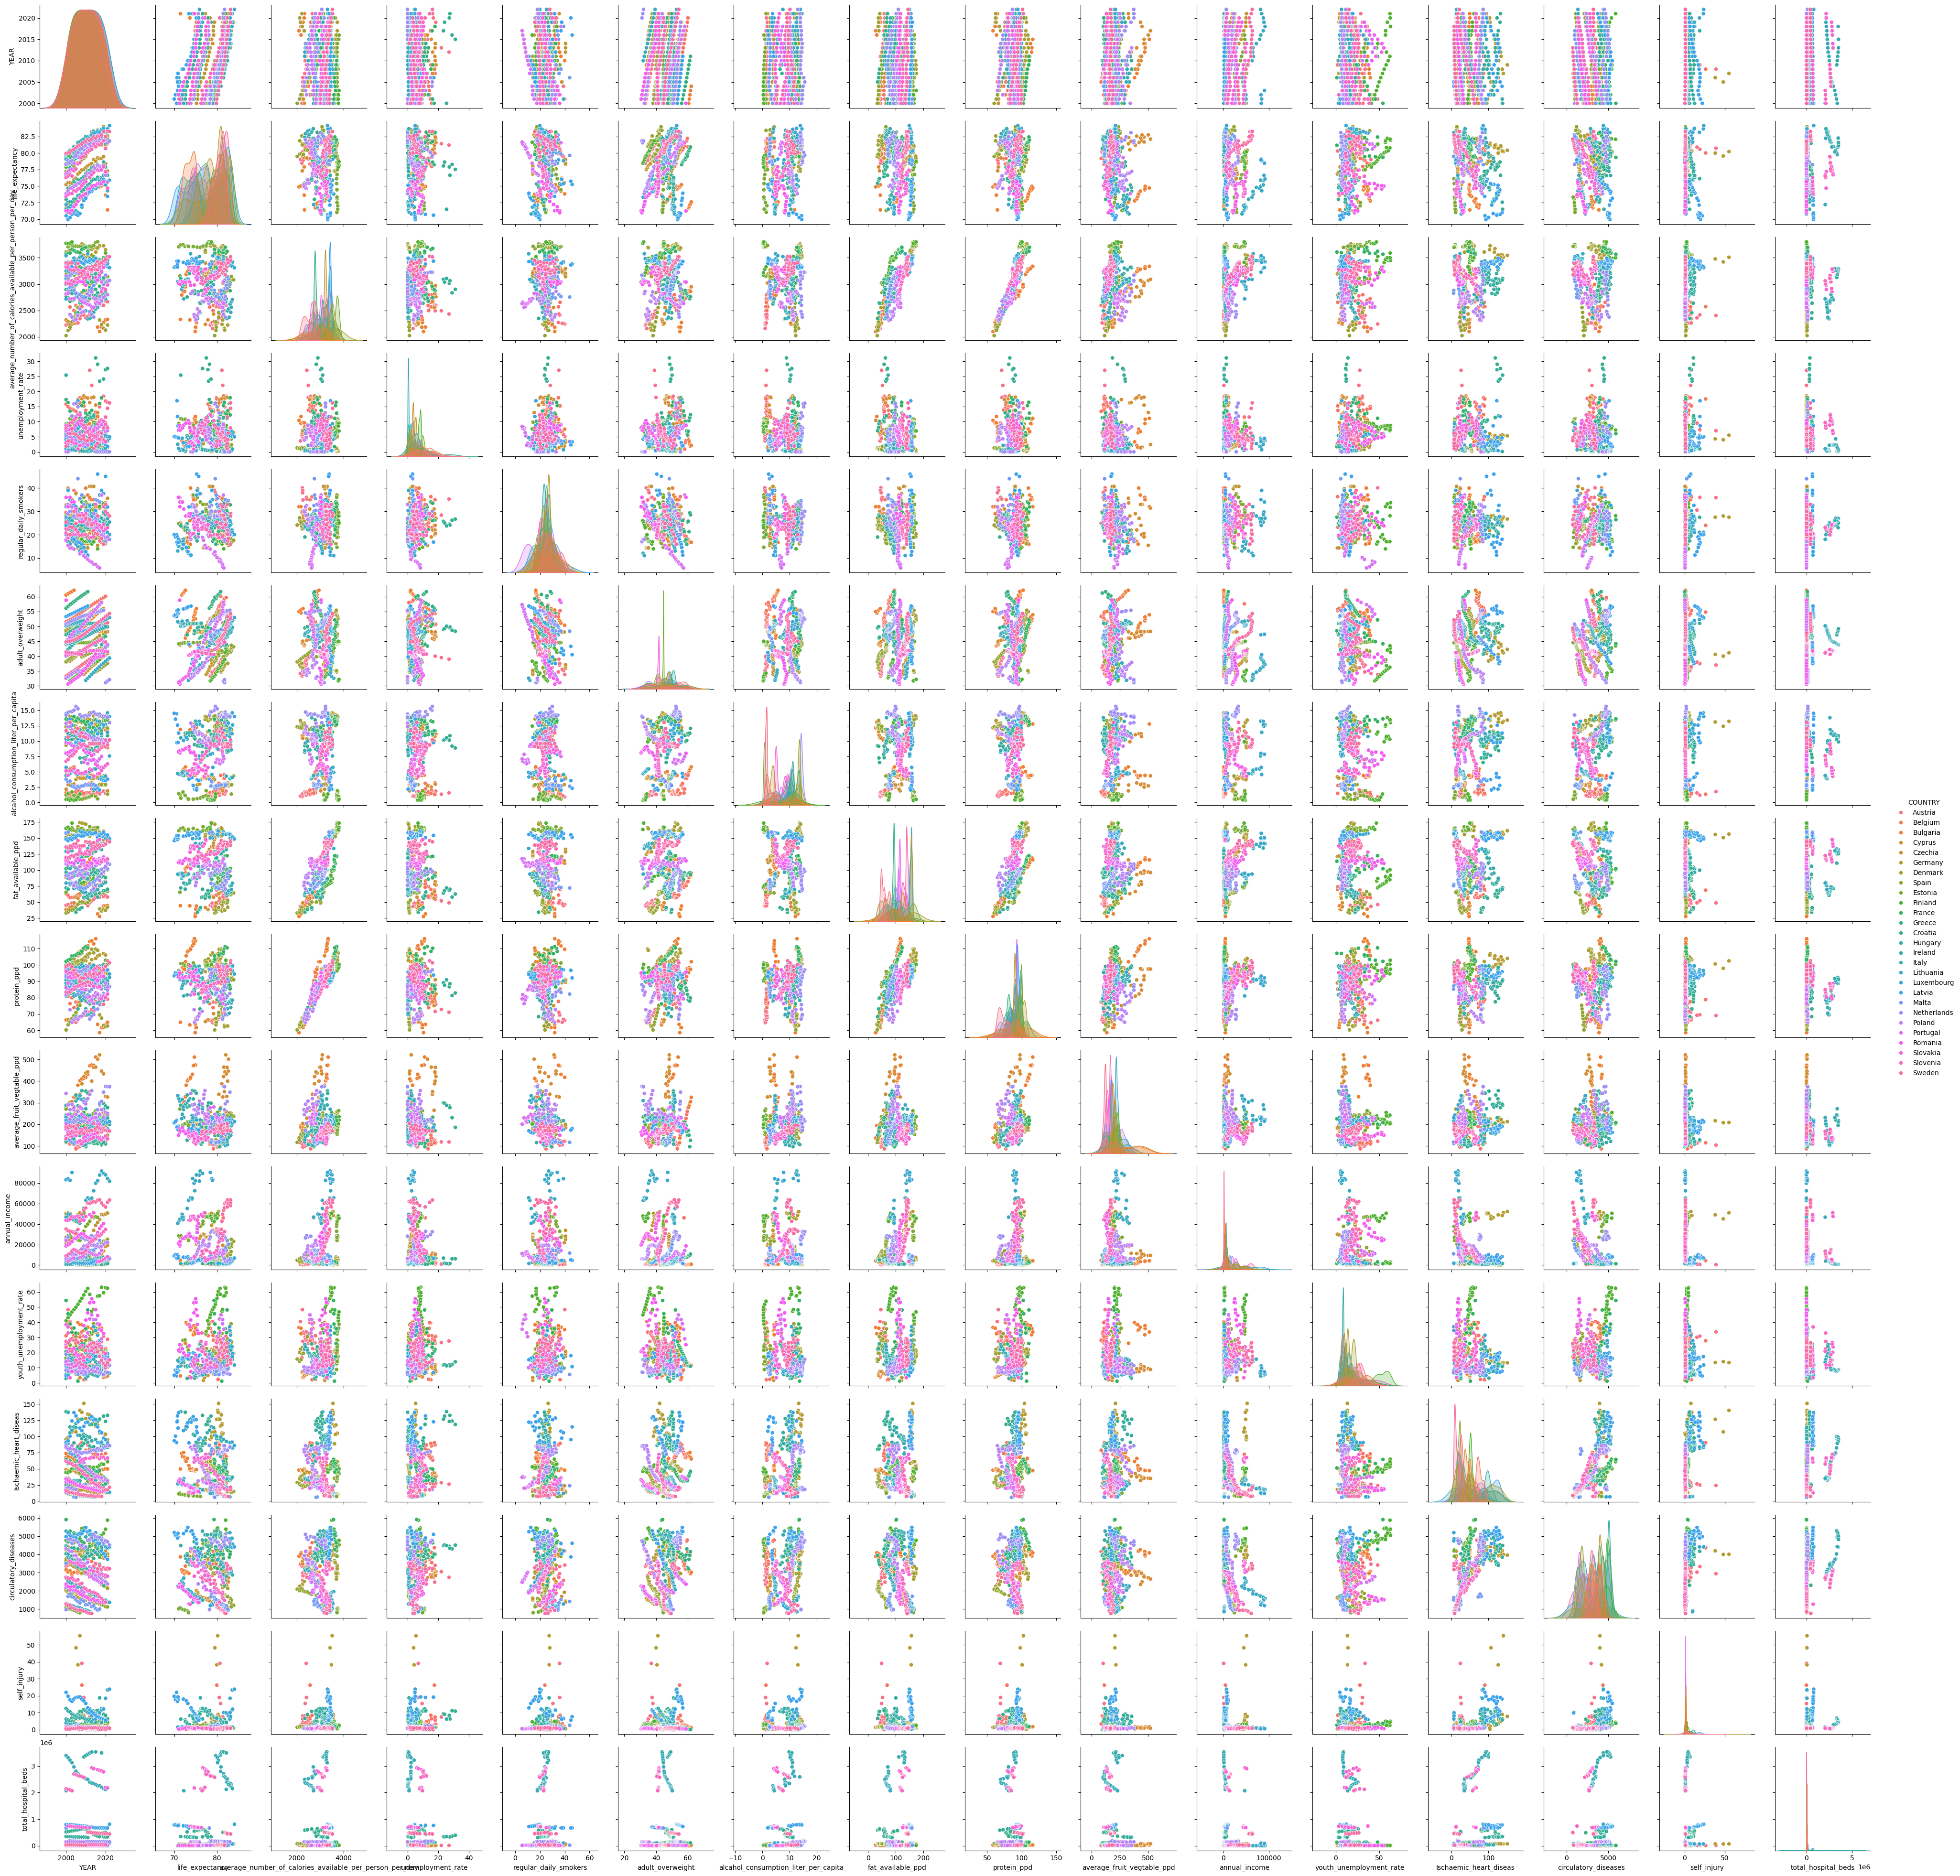

In [6]:
import seaborn as sns
sns.pairplot(df,hue="COUNTRY")

In [7]:
import numpy as np 
cols_to_bin = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "unemployment_rate",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
    "annual_income","youth_unemployment_rate",
    "Ischaemic_heart_diseas","circulatory_diseases",
    "self_injury","total_hospital_beds"   
]

for col in cols_to_bin:

    Q1 = np.percentile(df[f"{col}"], 25, interpolation = 'midpoint') 
    Q2 = np.percentile(df[f"{col}"], 50, interpolation = 'midpoint') 
    Q3 = np.percentile(df[f"{col}"], 75, interpolation = 'midpoint') 
    
    print('Q1 25 percentile of the given data is, ', Q1)
    print('Q1 50 percentile of the given data is, ', Q2)
    print('Q1 75 percentile of the given data is, ', Q3)

    IQR = Q3 - Q1 
    print('Interquartile range is', IQR)
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    print('low_limit is', low_lim)
    print('up_limit is', up_lim)
    outlier =[]
    for x in df[f"{col}"]:
        if ((x> up_lim) or (x<low_lim)):
            print(f"{col} had outlienr")
            outlier.append(x)

    print(' outlier in the dataset is', len(outlier))

Q1 25 percentile of the given data is,  75.89
Q1 50 percentile of the given data is,  79.33
Q1 75 percentile of the given data is,  81.345
Interquartile range is 5.454999999999998
low_limit is 67.70750000000001
up_limit is 89.5275
 outlier in the dataset is 0
Q1 25 percentile of the given data is,  2784.5
Q1 50 percentile of the given data is,  3117.5
Q1 75 percentile of the given data is,  3378.5
Interquartile range is 594.0
low_limit is 1893.5
up_limit is 4269.5
 outlier in the dataset is 0
Q1 25 percentile of the given data is,  2.635
Q1 50 percentile of the given data is,  5.3
Q1 75 percentile of the given data is,  8.45
Interquartile range is 5.8149999999999995
low_limit is -6.0875
up_limit is 17.1725
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemp

In [8]:
from scipy import stats
stats.zscore(df["life_expectancy"]).min()

np.float64(-2.5326224223821825)

In [9]:
data=df.copy()
data.COUNTRY.drop


<bound method Series.drop of 0      Austria
1      Austria
2      Austria
3      Austria
4      Austria
        ...   
553     Sweden
554     Sweden
555     Sweden
556     Sweden
557     Sweden
Name: COUNTRY, Length: 558, dtype: object>

In [10]:
data . drop ([ 'COUNTRY'] , axis =1 , inplace = True )


In [11]:
import pandas as pd
import numpy as np


def tertile_labels(s):
    return pd.qcut(s.rank(method="first"), q=3, labels=["LOW","MID","HIGH"])

cols_to_bin = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "unemployment_rate",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",  
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
    "annual_income",
    "youth_unemployment_rate",
    "Ischaemic_heart_diseas",
    "circulatory_diseases",
    "self_injury",
    "total_hospital_beds"
]

for c in cols_to_bin:
    df[c+"_bin"] = df.groupby("YEAR")[c].transform(tertile_labels)

# Build a string item for each binned column
rename_map = {
    "life_expectancy_bin": "LIFEEXP",
    "average_number_of_calories_available_per_person_per_day_bin": "CALORIES",
    "unemployment_rate_bin": "UNEMP",
    "regular_daily_smokers_bin": "SMOKING",
    "adult_overweight_bin": "OVERWT",
    "alcahol_consumption_liter_per_capita_bin": "ALCOHOL",
    "fat_available_ppd_bin": "FAT",
    "protein_ppd_bin": "PROTEIN",
    "average_fruit_vegtable_ppd_bin": "FRUITVEG",
    "annual_income_bin": "ANNUALINCOME",  
    "youth_unemployment_rate_bin": "YOUTH_UNEMP_RATE",  
    "Ischaemic_heart_diseas_bin": "HEARTDISEAS",  
    "circulatory_diseases_bin": "CIRCULATORYDISEAS",  
    "self_injury_bin": "SELFINJURY",  
    "total_hospital_beds_bin": "TOTALHOSPBED"  
}

item_cols = [c+"_bin" for c in cols_to_bin]
print(item_cols)

def row_to_items(row):
    items = []
    for c in item_cols:
        label = str(row[c])
        var = rename_map[c]
        items.append(f"{var}={label}")
    return items

# 1 transaction = one (COUNTRY, YEAR)
tx_df = (df.sort_values(["COUNTRY","YEAR"])
           .dropna(subset=item_cols)
           .drop_duplicates(subset=["COUNTRY","YEAR"]))

transactions = tx_df.apply(row_to_items, axis=1).tolist()
num_records = len(transactions)
print("Transactions:", num_records)

['life_expectancy_bin', 'average_number_of_calories_available_per_person_per_day_bin', 'unemployment_rate_bin', 'regular_daily_smokers_bin', 'adult_overweight_bin', 'alcahol_consumption_liter_per_capita_bin', 'fat_available_ppd_bin', 'protein_ppd_bin', 'average_fruit_vegtable_ppd_bin', 'annual_income_bin', 'youth_unemployment_rate_bin', 'Ischaemic_heart_diseas_bin', 'circulatory_diseases_bin', 'self_injury_bin', 'total_hospital_beds_bin']
Transactions: 558


In [12]:
df

COUNTRY  SEX    YEAR  life_expectancy  \
0    Austria  ALL  2000.0            78.47   
1    Austria  ALL  2001.0            78.95   
2    Austria  ALL  2002.0            79.01   
3    Austria  ALL  2003.0            78.89   
4    Austria  ALL  2004.0            79.43   
..       ...  ...     ...              ...   
553   Sweden  ALL  2018.0            82.71   
554   Sweden  ALL  2019.0            83.22   
555   Sweden  ALL  2020.0            82.46   
556   Sweden  ALL  2021.0            83.26   
557   Sweden  ALL  2022.0            83.24   

     average_number_of_calories_available_per_person_per_day  \
0                                               2223.0         
1                                               2242.0         
2                                               2156.0         
3                                               2270.0         
4                                               2254.0         
..                                                 ...         
553                                             3411.0         
554                                             3450.0         
555                                             3466.0         
556                                             3527.0         
557                                             3517.0         

     unemployment_rate  regular_daily_smokers  adult_overweight  \
0                  5.6                   29.5             33.30   
1                  5.1                   40.1             33.80   
2                  3.6                   24.7             34.20   
3                  4.4                   34.9             34.70   
4                  5.7                   39.0             35.10   
..                 ...                    ...               ...   
553                6.2                   18.4             52.23   
554                7.9                   15.9             52.76   
555               11.5                   33.0             53.29   
556               14.4                   29.0             53.80   
557               16.2                   28.0             54.32   

     alcahol_consumption_liter_per_capita  fat_available_ppd  ...  \
0                                    1.17              44.85  ...   
1                                    0.91              46.06  ...   
2                                    1.04              43.14  ...   
3                                    1.04              48.29  ...   
4                                    1.03              44.41  ...   
..                                    ...                ...  ...   
553                                  9.00             138.58  ...   
554                                  9.12             138.96  ...   
555                                  9.06             140.72  ...   
556                                  9.36             146.00  ...   
557                                 10.18             144.11  ...   

     alcahol_consumption_liter_per_capita_bin  fat_available_ppd_bin  \
0                                         LOW                    LOW   
1                                         LOW                    LOW   
2                                         LOW                    LOW   
3                                         LOW                    LOW   
4                                         LOW                    LOW   
..                                        ...                    ...   
553                                       MID                   HIGH   
554                                       MID                   HIGH   
555                                       MID                   HIGH   
556                                       MID                   HIGH   
557                                       MID                    MID   

     protein_ppd_bin  average_fruit_vegtable_ppd_bin  annual_income_bin  \
0                LOW                             LOW                LOW   
1                LOW              

In [13]:
import pyfpgrowth

# Choose minimum support as a COUNT like in your sheet:
# Example: require that an itemset appears in at least 20% of all (country,year) rows
min_support_frac = 0.10
sigma = max(1, int(np.floor(min_support_frac * num_records)))
print("Minimum support (count) =", sigma)

patterns = pyfpgrowth.find_frequent_patterns(transactions, sigma)
print("Frequent itemsets found:", len(patterns))

# Quick peek at biggest itemsets found

max_itemset_size=max(len(iset) for iset in patterns) 
print("Max frequent itemset size:", max_itemset_size)


Minimum support (count) = 55
Frequent itemsets found: 780
Max frequent itemset size: 4


In [14]:
min_conf=0.4
raw_rules=pyfpgrowth.generate_association_rules(patterns, min_conf) 

In [15]:
raw_rules

{('CIRCULATORYDISEAS=LOW', 'HEARTDISEAS=LOW'): (('SELFINJURY=LOW',),
  0.5774647887323944),
 ('CIRCULATORYDISEAS=LOW', 'UNEMP=MID'): (('HEARTDISEAS=LOW',),
  0.9090909090909091),
 ('HEARTDISEAS=LOW', 'UNEMP=MID'): (('CIRCULATORYDISEAS=LOW',),
  0.7142857142857143),
 ('FAT=HIGH', 'PROTEIN=HIGH'): (('ANNUALINCOME=HIGH',), 0.4782608695652174),
 ('FAT=HIGH', 'UNEMP=MID'): (('TOTALHOSPBED=MID',), 0.6931818181818182),
 ('CALORIES=HIGH', 'UNEMP=MID'): (('FAT=HIGH',), 0.8235294117647058),
 ('CALORIES=HIGH', 'FAT=HIGH', 'PROTEIN=HIGH'): (('TOTALHOSPBED=MID',),
  0.6972477064220184),
 ('CALORIES=HIGH', 'FAT=HIGH', 'UNEMP=MID'): (('PROTEIN=HIGH',), 0.8),
 ('CALORIES=HIGH', 'PROTEIN=HIGH', 'UNEMP=MID'): (('FAT=HIGH',),
  0.8115942028985508),
 ('FAT=HIGH', 'PROTEIN=HIGH', 'UNEMP=MID'): (('CALORIES=HIGH',),
  0.9824561403508771),
 ('CALORIES=HIGH', 'PROTEIN=HIGH'): (('FAT=HIGH',), 0.7218543046357616),
 ('CALORIES=HIGH',): (('FAT=HIGH',), 0.7591623036649214),
 ('CALORIES=HIGH', 'FAT=HIGH'): (('ALCOHO

In [16]:
from collections import Counter
import pandas as pd

rows = []
N = len(transactions)

for antecedent, (consequent, confidence) in raw_rules.items():
    # --- Normalize antecedent ---
    if isinstance(antecedent, (list, tuple, set, frozenset)):
        antecedent = {str(x) for x in antecedent}
    else:
        antecedent = {str(antecedent)}

    # --- Normalize consequent ---
    if isinstance(consequent, (list, tuple, set, frozenset)):
        consequent = {str(x) for x in consequent}
    else:
        consequent = {str(consequent)}

    union = antecedent | consequent

    # --- Support of union (antecedent+consequent) ---
    supp_union = sum(1 for basket in transactions if union.issubset(basket)) / N

    # --- Support of consequent ---
    supp_conseq = sum(1 for basket in transactions if consequent.issubset(basket)) / N

    # --- Lift ---
    lift = confidence / supp_conseq if supp_conseq > 0 else None

    rows.append({
        "antecedent": tuple(sorted(antecedent)),
        "consequent": tuple(sorted(consequent)),
        "support": supp_union,
        "confidence": confidence,
        "lift": lift
    })

rules_df = pd.DataFrame(rows).sort_values(["lift","confidence","support"], ascending=False)


In [17]:
rules_df.sort_values(by="confidence",ascending=False) 

antecedent  \
128  (ANNUALINCOME=LOW, CALORIES=LOW, FRUITVEG=LOW)   
118       (CALORIES=LOW, LIFEEXP=HIGH, PROTEIN=LOW)   
123           (CALORIES=LOW, FAT=LOW, FRUITVEG=LOW)   
30    (CIRCULATORYDISEAS=MID, FAT=LOW, PROTEIN=LOW)   
120               (CALORIES=LOW, TOTALHOSPBED=HIGH)   
..                                              ...   
3                          (FAT=HIGH, PROTEIN=HIGH)   
25                           (FAT=LOW, PROTEIN=LOW)   
12                        (CALORIES=HIGH, FAT=HIGH)   
18                                    (UNEMP=HIGH,)   
36                      (CALORIES=LOW, PROTEIN=LOW)   

                           consequent   support  confidence      lift  
128                    (PROTEIN=LOW,)  0.098566    1.000000  2.983957  
118                        (FAT=LOW,)  0.116487    1.000000  2.983957  
123                    (PROTEIN=LOW,)  0.132616    0.986667  2.944171  
30                    (CALORIES=LOW,)  0.112903    0.984375  2.937333  
120                    (PROTEIN=LOW,)  0.109319    0.983871  2.935829  
..                                ...       ...         ...       ...  
3                (ANNUALINCOME=HIGH,)  0.098566    0.478261  1.397223  
25   (CALORIES=LOW, TOTALHOSPBED=LOW)  0.100358    0.455285  2.490674  
12                    (ALCOHOL=HIGH,)  0.109319    0.420690  1.229031  
18                     (OVERWT=HIGH,)  0.137993    0.403141  1.177764  
36            (YOUTH_UNEMP_RATE=LOW,)  0.116487    0.401235  1.197267  

[211 rows x 5 columns]

In [18]:
rules_df["support"].max()

np.float64(0.25985663082437277)

In [19]:
rules_df["lift"]

122    4.583333
111    4.095528
116    3.929577
22     3.747253
126    3.105647
         ...   
29     1.465804
3      1.397223
12     1.229031
36     1.197267
18     1.177764
Name: lift, Length: 211, dtype: float64

In [20]:
df_filtered = rules_df.query('lift >3')
df_filtered


antecedent                        consequent  \
122      (CALORIES=LOW, FRUITVEG=LOW)   (ANNUALINCOME=LOW, PROTEIN=LOW)   
111      (CALORIES=LOW, LIFEEXP=HIGH)            (FAT=LOW, PROTEIN=LOW)   
116       (LIFEEXP=HIGH, PROTEIN=LOW)           (CALORIES=LOW, FAT=LOW)   
22        (FRUITVEG=LOW, PROTEIN=LOW)  (ANNUALINCOME=LOW, CALORIES=LOW)   
126  (ANNUALINCOME=LOW, FRUITVEG=LOW)       (CALORIES=LOW, PROTEIN=LOW)   

      support  confidence      lift  
122  0.098566    0.591398  4.583333  
111  0.116487    0.902778  4.095528  
116  0.116487    0.915493  3.929577  
22   0.098566    0.523810  3.747253  
126  0.098566    0.901639  3.105647

In [21]:
data . drop ([ 'SEX'] , axis =1 , inplace = True )

In [22]:
from sklearn . preprocessing import MinMaxScaler
minmax_scaled = MinMaxScaler().fit_transform (data)

In [23]:
from sklearn . decomposition import PCA
pca = PCA ()
principal_component=pca.fit_transform(data)

In [24]:
print(pca.explained_variance_ratio_)

[9.99317103e-01 6.80096436e-04 2.55134467e-06 2.37728827e-07
 8.70770070e-09 1.10077456e-09 6.97393820e-10 2.01257310e-10
 8.53084484e-11 7.32902005e-11 5.83325813e-11 3.78983809e-11
 3.63823117e-11 2.85652518e-11 2.02059550e-11 1.18572352e-11]


In [25]:
principal_component

array([[-3.38007857e+05, -1.76595426e+04, -2.00660037e+02, ...,
        -5.94778942e+00,  1.10594379e+00,  3.24273159e+00],
       [-3.38007957e+05, -1.76306511e+04, -1.40763422e+02, ...,
        -2.39275322e+00, -2.65809243e+00,  2.29025384e+00],
       [-3.37840945e+05, -1.76317109e+04, -9.44102312e+01, ...,
        -4.71480726e+00, -7.83547081e-01,  2.96816822e+00],
       ...,
       [ 1.01477508e+05,  3.99824414e+04,  8.21411308e+02, ...,
         1.64713957e+00,  1.92344687e+00,  2.34249392e-01],
       [ 1.00965343e+05,  4.45488885e+04,  9.64563544e+02, ...,
         1.71952497e+00,  4.71949188e+00,  8.19771288e-01],
       [ 9.33501216e+04,  4.67201982e+04,  9.83945673e+02, ...,
         2.94996863e+00,  4.50775518e+00,  4.08540858e-01]])

In [44]:
df.columns

Index(['COUNTRY', 'SEX', 'YEAR', 'life_expectancy',
       'average_number_of_calories_available_per_person_per_day',
       'unemployment_rate', 'regular_daily_smokers', 'adult_overweight',
       'alcahol_consumption_liter_per_capita', 'fat_available_ppd',
       'protein_ppd', 'average_fruit_vegtable_ppd', 'annual_income',
       'youth_unemployment_rate', 'Ischaemic_heart_diseas',
       'circulatory_diseases', 'self_injury', 'total_hospital_beds',
       'life_expectancy_bin',
       'average_number_of_calories_available_per_person_per_day_bin',
       'unemployment_rate_bin', 'regular_daily_smokers_bin',
       'adult_overweight_bin', 'alcahol_consumption_liter_per_capita_bin',
       'fat_available_ppd_bin', 'protein_ppd_bin',
       'average_fruit_vegtable_ppd_bin', 'annual_income_bin',
       'youth_unemployment_rate_bin', 'Ischaemic_heart_diseas_bin',
       'circulatory_diseases_bin', 'self_injury_bin',
       'total_hospital_beds_bin'],
      dtype='object')

In [27]:
low_inc_countries = df[(df['annual_income_bin'] == 'LOW') & (df['average_number_of_calories_available_per_person_per_day_bin'] == 'LOW')
& (df['average_fruit_vegtable_ppd_bin']=='LOW')]['COUNTRY'].unique()
print(low_inc_countries)

['Austria' 'Belgium' 'Bulgaria' 'Cyprus' 'Denmark' 'Greece' 'Croatia'
 'Italy']


In [ ]:
countries_rule1 = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Denmark', 'Greece', 'Croatia', 'Italy']
print(df["YEAR"].unique())

filtered_df_rule1 = df[
    (df["COUNTRY"].isin(countries_rule1))&
    (df["YEAR"].between(2002, 2022))]
low_avg_income_per_country=(
    filtered_df_rule1.groupby("COUNTRY")["annual_income"]
    .mean()
    .reset_index()
    .sort_values(by="annual_income", ascending=False)

)

print(low_avg_income_per_country)
#Countries, not in the minde list counties
high_income_countries=df[ (~df["COUNTRY"].isin(countries_rule1))&
    (df["YEAR"].between(2002, 2022))]

high_mid_avg_income_per_country=(
    high_income_countries.groupby("COUNTRY")["annual_income"]
    .mean()
    .reset_index()
    .sort_values(by="annual_income", ascending=True)

)
print(high_mid_avg_income_per_country)

[2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011.
 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021. 2022.]
    COUNTRY  annual_income
4    Cyprus    8698.500000
1   Belgium    5543.684211
6    Greece    5280.000000
3   Croatia    4613.157895
5   Denmark    4513.500000
7     Italy    3218.420526
2  Bulgaria    2866.000000
0   Austria    1215.000000
        COUNTRY  annual_income
6       Ireland    2682.519286
3        France    2932.666667
5       Hungary    3772.777778
7        Latvia    5672.826500
13     Portugal    9586.666667
9    Luxembourg   10802.132857
17        Spain   13966.000000
10        Malta   14190.625000
12       Poland   16340.500000
16     Slovenia   20200.526316
11  Netherlands   20669.047619
2       Finland   20753.157895
4       Germany   21884.444444
14      Romania   28654.444444
15     Slovakia   33011.666667
0       Czechia   34057.500000
1       Estonia   34864.000000
18       Sweden   52207.142857
8     Lithuania   65975.714